# POS Tagging Pipelines with Network Graph Visualization
This notebook demonstrates multiple approaches to Part-of-Speech tagging in Python and visualizes each pipeline as a directed graph using NetworkX.

In [1]:
!pip install sklearn_crfsuite

## 1. Rule‑Based Pipeline (NLTK)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


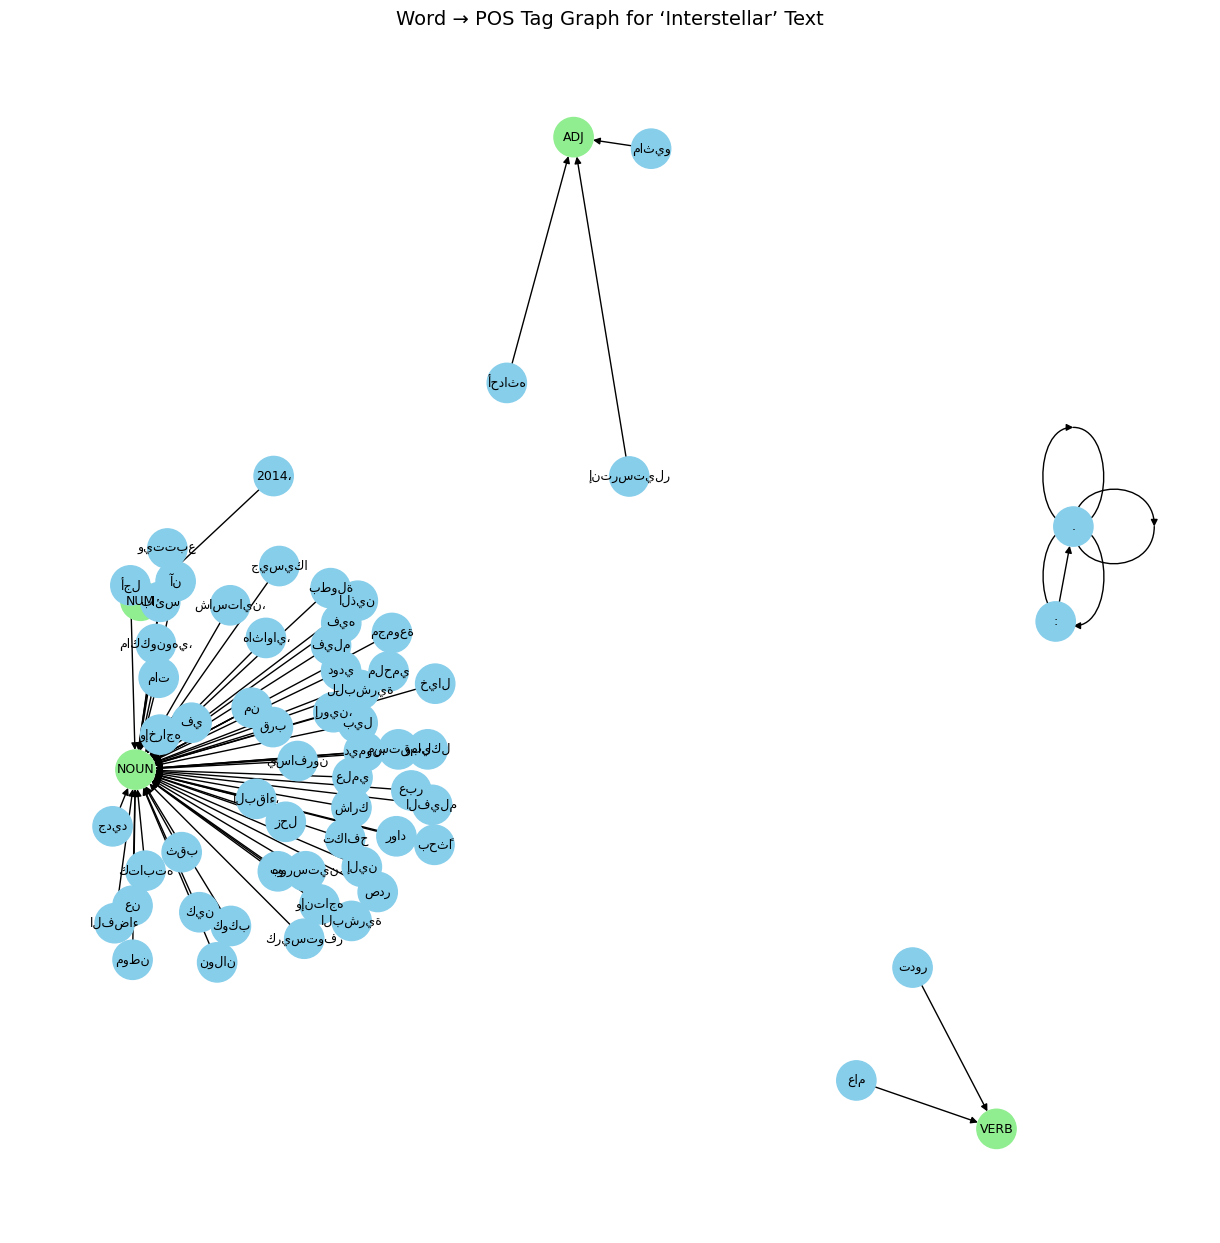

In [2]:
import nltk
from nltk import word_tokenize, pos_tag
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Download models if you haven't already
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

text = """
إنترستيلر هو فيلم خيال علمي ملحمي صدر عام 2014، شارك في كتابته وإخراجه وإنتاجه كريستوفر نولان.
بطولة: ماثيو ماككونوهِي، آن هاثاواي، جيسيكا شاستاين، بيل إروين، إلين بورستين، مات ديمون، ومايكل كين.
تدور أحداثه في مستقبل بائس تكافح فيه البشرية من أجل البقاء، ويتتبع الفيلم مجموعة من رواد الفضاء الذين يسافرون عبر ثقب دودي قرب كوكب زحل بحثًا عن موطن جديد للبشرية.
"""
# Tokenize and POS‑tag
tokens = word_tokenize(text)
tags = pos_tag(tokens, tagset="universal")

# Build a DataFrame edge list
df = pd.DataFrame(tags, columns=["word", "tag"])

# Create directed multigraph from DataFrame
G = nx.from_pandas_edgelist(
    df,
    source="word",
    target="tag",
    create_using=nx.MultiDiGraph()
)

# Mark node types for coloring
for node in G.nodes():
    # if node is any word in the 'word' column, it's a word‑node; otherwise it's a tag
    G.nodes[node]['type'] = 'word' if node in df['word'].values else 'tag'

# Prepare colors: skyblue for words, lightgreen for tags
node_colors = [
    'skyblue' if G.nodes[n]['type'] == 'word' else 'lightgreen'
    for n in G.nodes()
]

# Plot with spring layout, colored nodes, and edge colormap
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    edge_cmap=plt.cm.Blues,
    node_size=800,
    font_size=9
)

plt.title("Word → POS Tag Graph for ‘Interstellar’ Text", fontsize=14)
plt.axis("off")
plt.show()


## 2. Statistical CRF Pipeline (sklearn-crfsuite)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


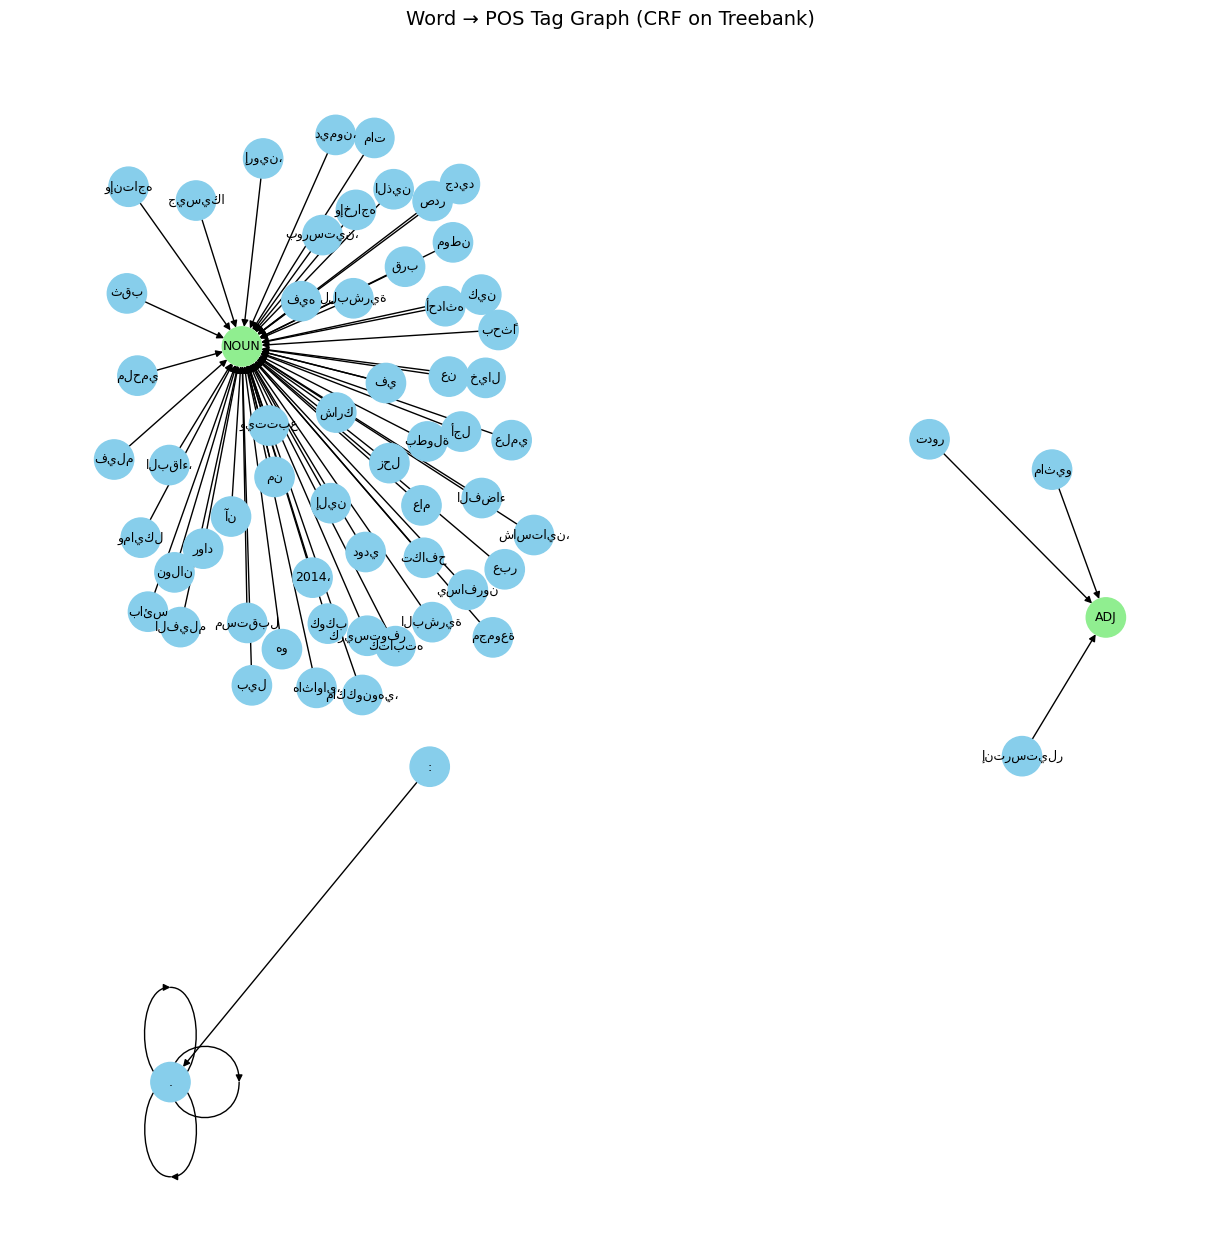

In [3]:
import nltk
from nltk import word_tokenize
from nltk.corpus import treebank
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sklearn_crfsuite

# 1. Download required NLTK data
nltk.download('punkt')
nltk.download('treebank')
nltk.download('universal_tagset')

# 2. Load POS‐tagged sentences from the Treebank with universal tags
tagged_sents = treebank.tagged_sents(tagset='universal')

# 3. Feature extractor for CRF
def word2features(sent, i):
    word = sent[i][0]
    return {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'prev-word.lower()': '' if i==0 else sent[i-1][0].lower(),
        'next-word.lower()': '' if i==len(sent)-1 else sent[i+1][0].lower(),
    }

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label in sent]

# 4. Prepare training data
X_train = [sent2features(s) for s in tagged_sents]
y_train = [sent2labels(s)  for s in tagged_sents]

# 5. Train CRF
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,            # L1 penalty
    c2=0.1,            # L2 penalty
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

# 6. text
text = """
إنترستيلر هو فيلم خيال علمي ملحمي صدر عام 2014، شارك في كتابته وإخراجه وإنتاجه كريستوفر نولان.
بطولة: ماثيو ماككونوهِي، آن هاثاواي، جيسيكا شاستاين، بيل إروين، إلين بورستين، مات ديمون، ومايكل كين.
تدور أحداثه في مستقبل بائس تكافح فيه البشرية من أجل البقاء، ويتتبع الفيلم مجموعة من رواد الفضاء الذين يسافرون عبر ثقب دودي قرب كوكب زحل بحثًا عن موطن جديد للبشرية.
"""

# 7. Tokenize & featureize
tokens = word_tokenize(text)
# Build a “sentence” of (word,?) tuples so feature extractor works
dummy_sent = [(w, None) for w in tokens]
features = sent2features(dummy_sent)

# 8. Predict using CRF
predicted_tags = crf.predict_single(features)

# 9. Build DataFrame of word→tag
df = pd.DataFrame({'word': tokens, 'tag': predicted_tags})

# 10. Create directed multigraph
G = nx.from_pandas_edgelist(
    df, source='word', target='tag', create_using=nx.MultiDiGraph()
)

# 11. Mark node types (word vs. tag)
for n in G.nodes():
    G.nodes[n]['type'] = 'word' if n in df['word'].values else 'tag'

# 12. Assign colors
node_colors = [
    'skyblue' if G.nodes[n]['type']=='word' else 'lightgreen'
    for n in G.nodes()
]

# 13. Draw
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    edge_cmap=plt.cm.Blues,
    node_size=800,
    font_size=9
)
plt.title("Word → POS Tag Graph (CRF on Treebank)", fontsize=14)
plt.axis('off')
plt.show()


## 3. spaCy Built‑in Pipeline

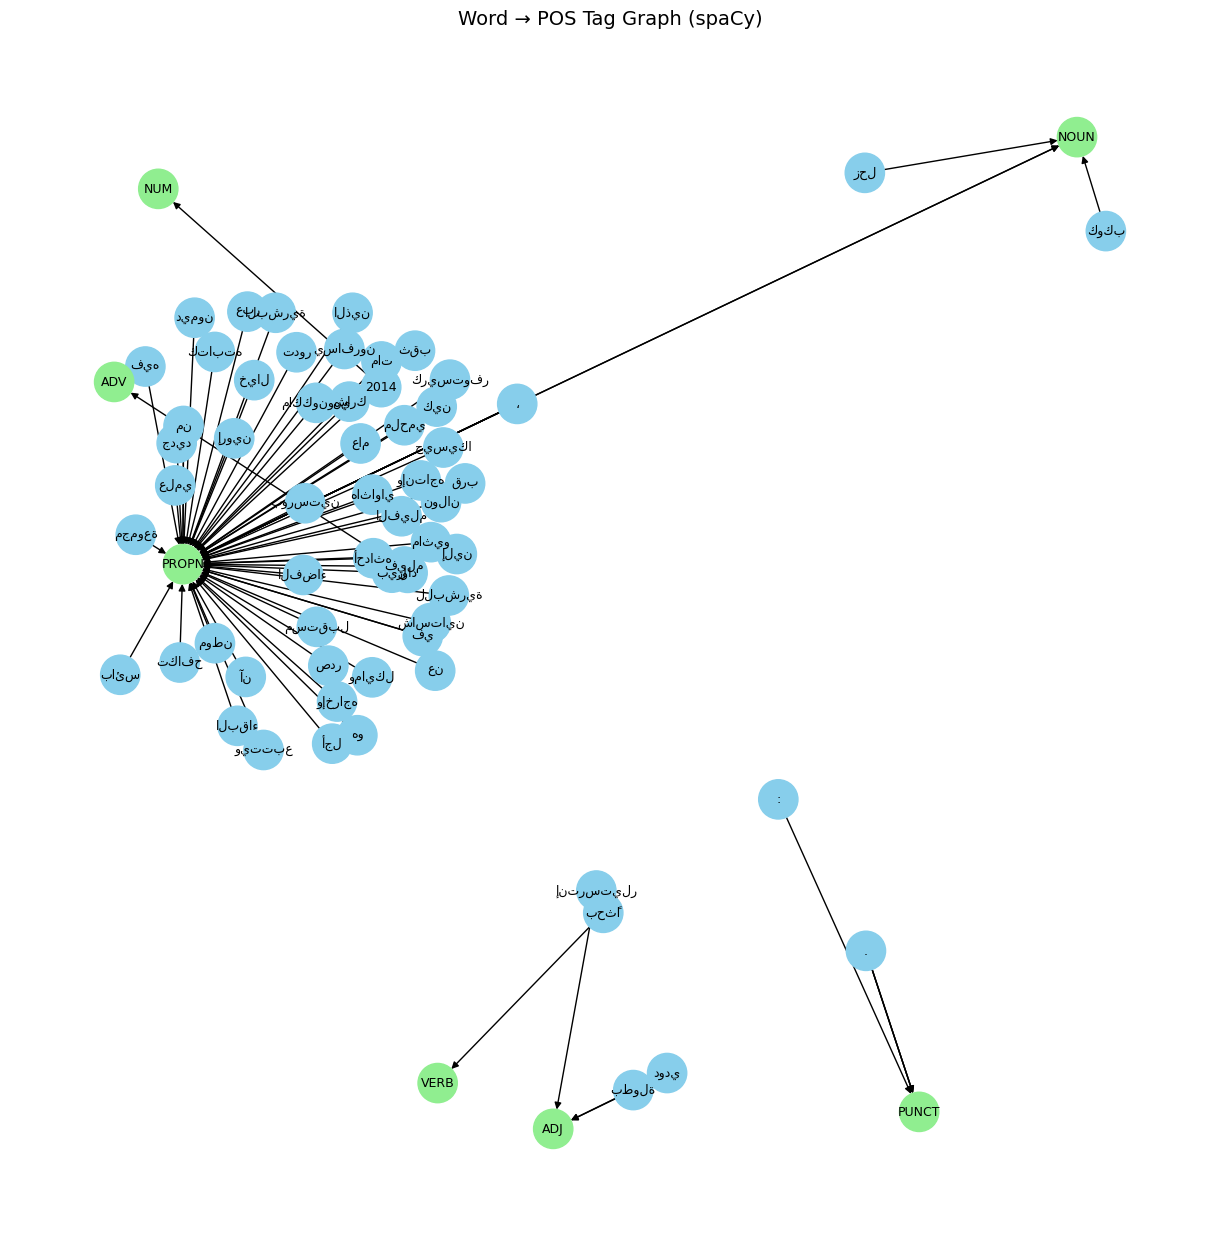

In [4]:
import spacy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Load spaCy English model (make sure you've run: python -m spacy download en_core_web_sm)
nlp = spacy.load('en_core_web_sm')

# 2. text
text = """
إنترستيلر هو فيلم خيال علمي ملحمي صدر عام 2014، شارك في كتابته وإخراجه وإنتاجه كريستوفر نولان.
بطولة: ماثيو ماككونوهِي، آن هاثاواي، جيسيكا شاستاين، بيل إروين، إلين بورستين، مات ديمون، ومايكل كين.
تدور أحداثه في مستقبل بائس تكافح فيه البشرية من أجل البقاء، ويتتبع الفيلم مجموعة من رواد الفضاء الذين يسافرون عبر ثقب دودي قرب كوكب زحل بحثًا عن موطن جديد للبشرية.
"""

# 3. Process text
doc = nlp(text)

# 4. Extract word → universal POS tag pairs
rows = [(token.text, token.pos_) for token in doc if not token.is_space]
df = pd.DataFrame(rows, columns=['word', 'tag'])

# 5. Build directed multigraph
G = nx.from_pandas_edgelist(df, source='word', target='tag', create_using=nx.MultiDiGraph())

# 6. Mark node types
for n in G.nodes():
    G.nodes[n]['type'] = 'word' if n in df['word'].values else 'tag'

# 7. Assign colors
node_colors = ['skyblue' if G.nodes[n]['type']=='word' else 'lightgreen' for n in G.nodes()]

# 8. Visualize
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    edge_cmap=plt.cm.Blues,
    node_size=800,
    font_size=9
)
plt.title("Word → POS Tag Graph (spaCy)", fontsize=14)
plt.axis('off')
plt.show()


## 4. Hugging Face Transformer Pipeline

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-egy were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 

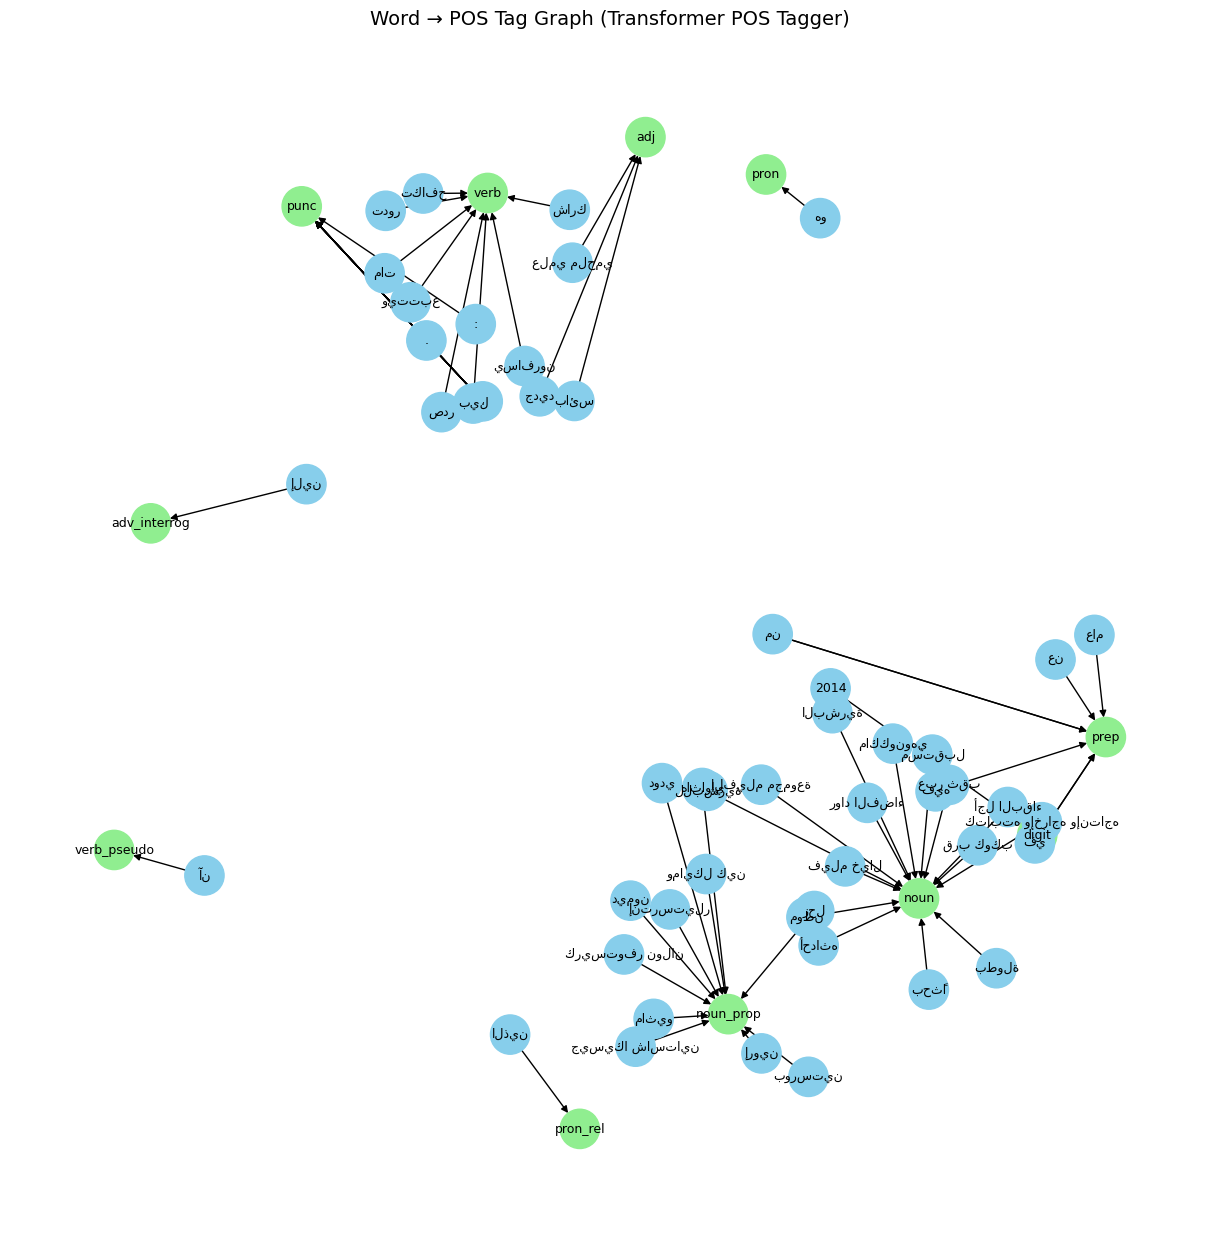

In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Load tokenizer & model (this one is fine-tuned on the Universal POS tagset)
#MODEL_NAME = "vblagoje/bert-english-uncased-finetuned-pos"
MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-egy"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

# 2. Create a token-classification pipeline with simple aggregation
pos_tagger = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"   # merges wordpieces into full words
)

# 3. text
text = """
إنترستيلر هو فيلم خيال علمي ملحمي صدر عام 2014، شارك في كتابته وإخراجه وإنتاجه كريستوفر نولان.
بطولة: ماثيو ماككونوهِي، آن هاثاواي، جيسيكا شاستاين، بيل إروين، إلين بورستين، مات ديمون، ومايكل كين.
تدور أحداثه في مستقبل بائس تكافح فيه البشرية من أجل البقاء، ويتتبع الفيلم مجموعة من رواد الفضاء الذين يسافرون عبر ثقب دودي قرب كوكب زحل بحثًا عن موطن جديد للبشرية.
"""
# 4. Run POS tagging
results = pos_tagger(text)

# 5. Extract (word, tag) pairs
rows = [(res["word"], res["entity_group"]) for res in results]
df   = pd.DataFrame(rows, columns=["word", "tag"])

# 6. Build a directed multigraph
G = nx.from_pandas_edgelist(
    df,
    source="word",
    target="tag",
    create_using=nx.MultiDiGraph()
)

# 7. Mark node types for coloring
for n in G.nodes():
    G.nodes[n]["type"] = "word" if n in df["word"].values else "tag"

node_colors = [
    "skyblue" if G.nodes[n]["type"] == "word" else "lightgreen"
    for n in G.nodes()
]

# 8. Visualize with spring layout
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    edge_cmap=plt.cm.Blues,
    node_size=800,
    font_size=9
)

plt.title("Word → POS Tag Graph (Transformer POS Tagger)", fontsize=14)
plt.axis("off")
plt.show()
